In [1]:
! pip install torch_optimizer

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 61 kB 16.1 MB/s eta 0:00:01


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from itertools import product
from torch import tensor
import pickle
import time
import torch_optimizer as optim

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
resume = True

if resume: 
    with open('sham_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sham = arr["acc"]
        test_loss_history_sham = arr["loss"]
        loss_in_training_sham = arr["loss_train"]
        time_learning_sham = arr["time"]
else:
    test_accuracy_history_sham, test_loss_history_sham, loss_in_training_sham, time_learning_sham = {}, {}, {}, {}

In [5]:
import tqdm

In [9]:
l = product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4])

In [10]:
l = list(l)
l.append((1, 0.0001))
l.append((5, 0.0001))
l.append((0.5, 0.0001))
l.append((0.2, 0.0001))
l.append((0.15, 0.0001))
#l.append((0.13, 0.0001))

l.append((0.15, 0))
l.append((0.2, 0))
l.append((0.5, 0))
# l.append((1, 0))
l.append((0.6, 0))
l.append((1, 0.0))
l.append((2, 0.0))

In [7]:
del test_accuracy_history_sham['schedule_1.5']
# del test_accuracy_history_sham[(0.8, 0)]

In [8]:
test_accuracy_history_sham

{(0.1, 0.001): [0.2764,
  0.3606,
  0.4242,
  0.488,
  0.5246,
  0.535,
  0.5838,
  0.5894,
  0.6074,
  0.618,
  0.6318,
  0.6334,
  0.6394,
  0.6618,
  0.6544,
  0.668,
  0.6762,
  0.6756,
  0.6804,
  0.6824],
 (0.1, 0.0003): [0.3354,
  0.4128,
  0.468,
  0.5172,
  0.5656,
  0.5718,
  0.6082,
  0.6218,
  0.6308,
  0.6418,
  0.6432,
  0.6552,
  0.6598,
  0.6702,
  0.6786,
  0.6844,
  0.6922,
  0.6934,
  0.702,
  0.7002],
 (0.1, 0.0001): [0.3828,
  0.4754,
  0.5278,
  0.5754,
  0.5978,
  0.619,
  0.6274,
  0.6392,
  0.663,
  0.672,
  0.6744,
  0.686,
  0.6786,
  0.6958,
  0.699,
  0.704,
  0.7052,
  0.7106,
  0.7178,
  0.7138],
 (0.1, 0): [0.5796,
  0.6368,
  0.6534,
  0.6878,
  0.6872,
  0.6922,
  0.6938,
  0.6978,
  0.6994,
  0.6904,
  0.689,
  0.6844,
  0.6794,
  0.6778,
  0.6792,
  0.6802,
  0.6682,
  0.6768,
  0.6748,
  0.6778],
 (0.03, 0.001): [0.4392,
  0.4914,
  0.5194,
  0.5516,
  0.5708,
  0.5882,
  0.5956,
  0.603,
  0.6164,
  0.625,
  0.6202,
  0.6312,
  0.626,
  0.6404,
  0

In [ ]:
for learning_rate, weight_decay in l:
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sham:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = optim.Shampoo(lenet.parameters(), lr=learning_rate, momentum=0.0, weight_decay=weight_decay, epsilon=1e-5, update_freq=1)
    
    test_loss_history_sham[key] = list()
    test_accuracy_history_sham[key] = list()
    loss_in_training_sham[key] = list()
    time_learning_sham[key] = list()

    for epoch in tqdm.tqdm(range(20)):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            optimizer.zero_grad()
            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch) 
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            try:
                optimizer.step()
            except:
                print("Optimizer or preconditioner step failed")
                pass
            sum_los += float(loss_value)
            
        time_learning_sham[key].append(time.time() - start_time)
        loss_in_training_sham[key].append(sum_los/450)
        print(sum_los/450)
            
        correct = 0
        total = 0
        los = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value               
        
        test_loss_history_sham[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
    
        test_accuracy_history_sham[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
    
    print(test_accuracy_history_sham[(learning_rate, weight_decay)])
    print(loss_in_training_sham[(learning_rate, weight_decay)])
    with open('sham_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sham, "loss": test_loss_history_sham, "loss_train":loss_in_training_sham, "time":time_learning_sham}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = optim.Shampoo(lenet.parameters(), lr=3, momentum=0.0, weight_decay=0, epsilon=1e-5, update_freq=1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

test_loss_history_sham['schedule_3'] = list()
test_accuracy_history_sham['schedule_3'] = list()
loss_in_training_sham['schedule_3'] = list()
time_learning_sham['schedule_3'] = list()

for epoch in tqdm.tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()
        X_batch, y_batch = data
        #X_batch, y_batch = Variable(X_batch, volatile=False), Variable(y_batch, volatile=False)
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        try:
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass
        sum_los += float(loss_value)
    
    scheduler.step()
    time_learning_sham['schedule_3'].append(time.time() - start_time)
    loss_in_training_sham['schedule_3'].append(sum_los/450)
    print(sum_los/450)

    correct = 0
    total = 0
    los = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value               

    test_loss_history_sham['schedule_3'].append(los/50)
    print('los epoch', epoch, ':', los/50)

    test_accuracy_history_sham['schedule_3'].append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_sham['schedule_3'])
print(loss_in_training_sham['schedule_3'])
with open('sham_big_results.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sham, "loss": test_loss_history_sham, "loss_train":loss_in_training_sham, "time":time_learning_sham}, f)

  0%|          | 0/20 [00:00<?, ?it/s]

15.158353005515204


  5%|▌         | 1/20 [09:20<2:57:37, 560.94s/it]

los epoch 0 : tensor(25.9405, device='cuda:0')
accuracy epoch 0 : 0.3558
10.982059313456217


 10%|█         | 2/20 [19:20<2:55:08, 583.82s/it]

los epoch 1 : tensor(1.5846, device='cuda:0')
accuracy epoch 1 : 0.6128
1.407880535920461


 15%|█▌        | 3/20 [29:42<2:50:16, 600.99s/it]

los epoch 2 : tensor(1.0337, device='cuda:0')
accuracy epoch 2 : 0.67
0.9469110892878638


 20%|██        | 4/20 [40:04<2:42:28, 609.30s/it]

los epoch 3 : tensor(0.8356, device='cuda:0')
accuracy epoch 3 : 0.7244
0.7186496071683036


 25%|██▌       | 5/20 [50:16<2:32:33, 610.24s/it]

los epoch 4 : tensor(0.8662, device='cuda:0')
accuracy epoch 4 : 0.7208
0.5614830414454143


 30%|███       | 6/20 [1:00:24<2:22:12, 609.46s/it]

los epoch 5 : tensor(0.7813, device='cuda:0')
accuracy epoch 5 : 0.756
0.43348857313394545


 35%|███▌      | 7/20 [1:10:10<2:10:23, 601.84s/it]

los epoch 6 : tensor(0.7828, device='cuda:0')
accuracy epoch 6 : 0.7612
0.31557384570439656


 40%|████      | 8/20 [1:20:04<1:59:52, 599.35s/it]

los epoch 7 : tensor(0.8280, device='cuda:0')
accuracy epoch 7 : 0.7644
0.2104290049109194


 45%|████▌     | 9/20 [1:30:19<1:50:47, 604.31s/it]

los epoch 8 : tensor(0.9012, device='cuda:0')
accuracy epoch 8 : 0.765
0.11752297680411074


 50%|█████     | 10/20 [1:40:22<1:40:39, 603.97s/it]

los epoch 9 : tensor(0.9683, device='cuda:0')
accuracy epoch 9 : 0.7636
0.05744325610912508


 55%|█████▌    | 11/20 [1:50:31<1:30:49, 605.49s/it]

los epoch 10 : tensor(1.0481, device='cuda:0')
accuracy epoch 10 : 0.7678
0.028214970590132806


 60%|██████    | 12/20 [2:00:32<1:20:32, 604.11s/it]

los epoch 11 : tensor(1.1445, device='cuda:0')
accuracy epoch 11 : 0.7648
0.015442741825762722


 65%|██████▌   | 13/20 [2:10:31<1:10:18, 602.61s/it]

los epoch 12 : tensor(1.1666, device='cuda:0')
accuracy epoch 12 : 0.7692
0.00955974622681323


 70%|███████   | 14/20 [2:20:35<1:00:17, 602.91s/it]

los epoch 13 : tensor(1.2173, device='cuda:0')
accuracy epoch 13 : 0.7668
0.007117965289702018


 75%|███████▌  | 15/20 [2:30:46<50:26, 605.30s/it]  

los epoch 14 : tensor(1.2385, device='cuda:0')
accuracy epoch 14 : 0.768
0.005665985261245321


 80%|████████  | 16/20 [2:40:37<40:03, 600.95s/it]

los epoch 15 : tensor(1.2438, device='cuda:0')
accuracy epoch 15 : 0.7696
0.005279910614869247


 85%|████████▌ | 17/20 [2:50:52<30:15, 605.28s/it]

los epoch 16 : tensor(1.2590, device='cuda:0')
accuracy epoch 16 : 0.7654
0.004885604349741091


 90%|█████████ | 18/20 [3:00:57<20:10, 605.26s/it]

los epoch 17 : tensor(1.2698, device='cuda:0')
accuracy epoch 17 : 0.77
0.004828460243944493


 95%|█████████▌| 19/20 [3:10:51<10:01, 601.72s/it]

los epoch 18 : tensor(1.2628, device='cuda:0')
accuracy epoch 18 : 0.7662
0.004472971064193795


100%|██████████| 20/20 [3:21:03<00:00, 603.19s/it]

los epoch 19 : tensor(1.2807, device='cuda:0')
accuracy epoch 19 : 0.7664
[0.3558, 0.6128, 0.67, 0.7244, 0.7208, 0.756, 0.7612, 0.7644, 0.765, 0.7636, 0.7678, 0.7648, 0.7692, 0.7668, 0.768, 0.7696, 0.7654, 0.77, 0.7662, 0.7664]
[15.158353005515204, 10.982059313456217, 1.407880535920461, 0.9469110892878638, 0.7186496071683036, 0.5614830414454143, 0.43348857313394545, 0.31557384570439656, 0.2104290049109194, 0.11752297680411074, 0.05744325610912508, 0.028214970590132806, 0.015442741825762722, 0.00955974622681323, 0.007117965289702018, 0.005665985261245321, 0.005279910614869247, 0.004885604349741091, 0.004828460243944493, 0.004472971064193795]


In [11]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink', 'pink', 'olive','violet', 'lime', 'tomato']

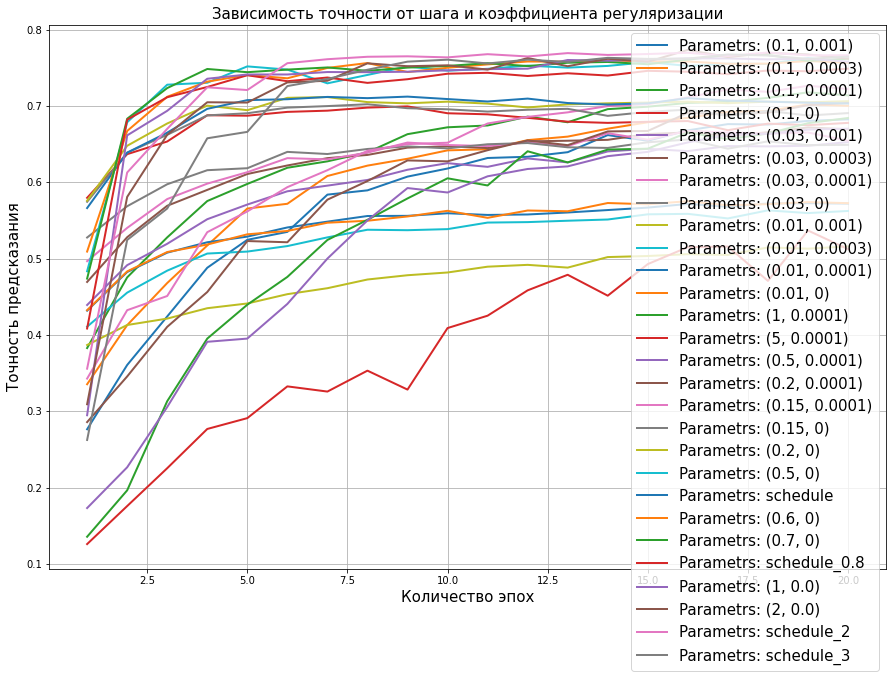

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sham.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2)
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

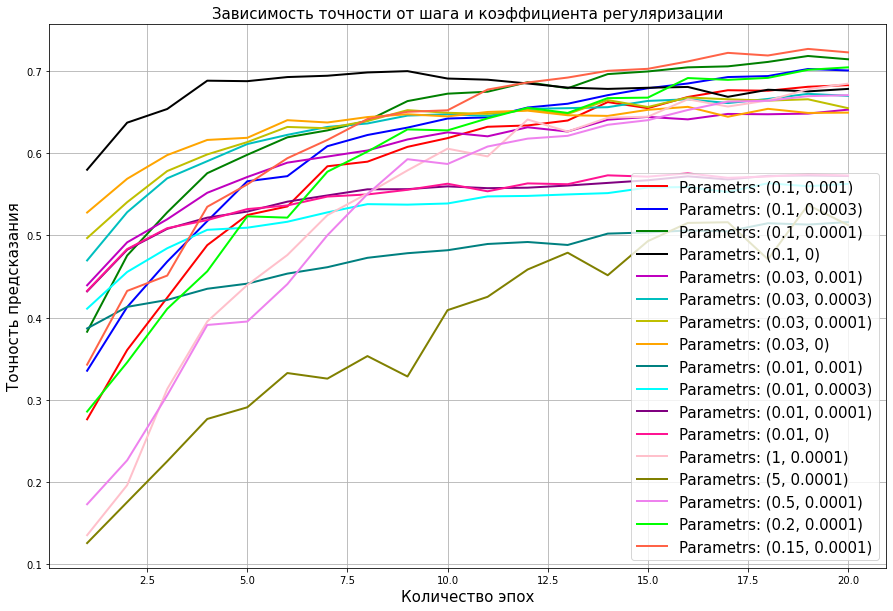

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sham.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
# plt.savefig('sgd_1_accrucy.png')

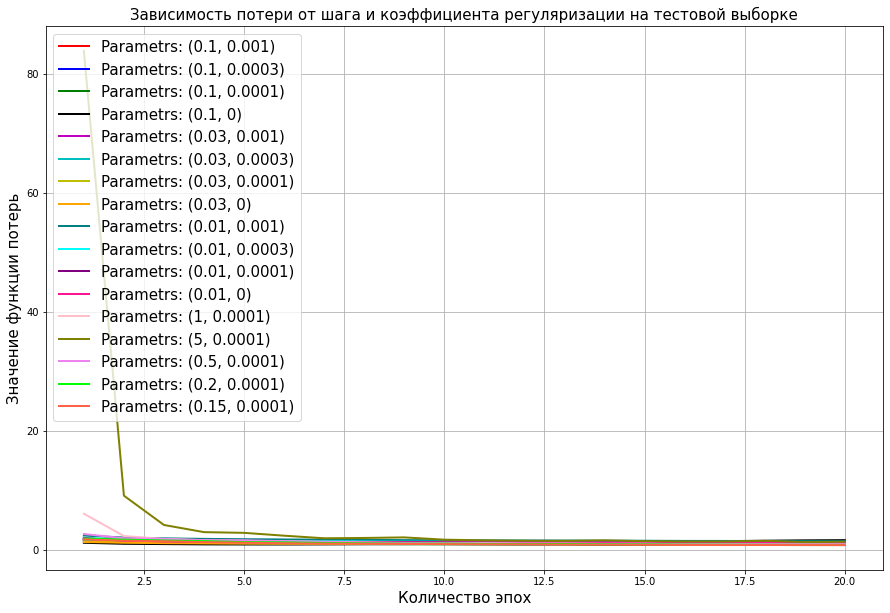

In [13]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sham.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)
plt.savefig('sgd_1_loss.png')

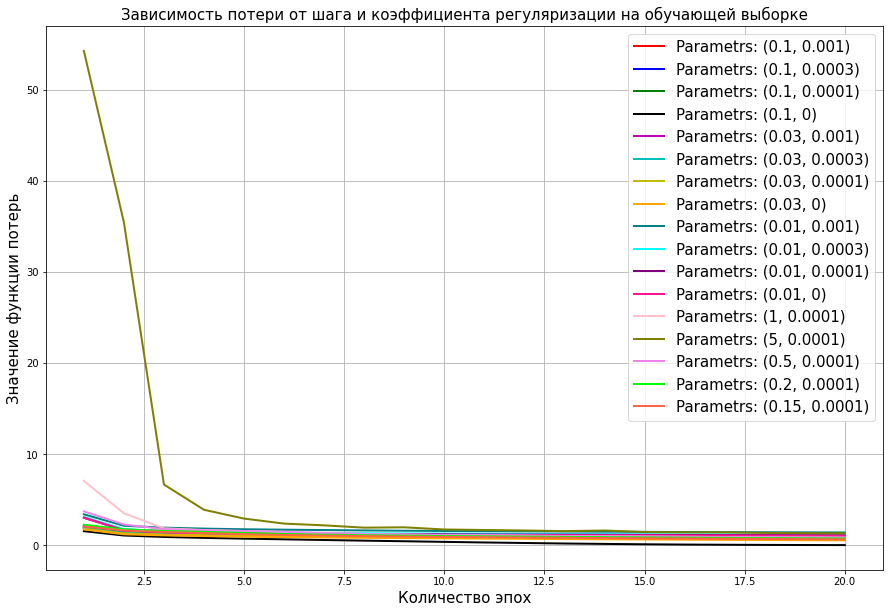

In [14]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sham.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_loss_train.png')

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [10]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = optim.Shampoo(lenet.parameters(), lr=2, momentum=0.0, weight_decay=0, epsilon=1e-5, update_freq=1)
    

test_loss_history_sham = list()
test_accuracy_history_sham = list()
loss_in_training_sham = list()
time_learning_sham = list()

for epoch in tqdm.tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        try:
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass
        
    time_learning_sham.append(time.time() - start_time)
    loss_in_training_sham.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sham.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_sham.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_sham)
print(loss_in_training_sham)
with open('sham_bresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sham, "loss": test_loss_history_sham, "loss_train":loss_in_training_sham, "time":time_learning_sham}, f)

  5%|▌         | 1/20 [10:52<3:26:42, 652.76s/it]

los epoch 0 : tensor(25.0859, device='cuda:0')
accuracy epoch 0 : 0.2759


 10%|█         | 2/20 [22:41<3:25:46, 685.94s/it]

los epoch 1 : tensor(1.5688, device='cuda:0')
accuracy epoch 1 : 0.5871


 15%|█▌        | 3/20 [33:50<3:12:06, 678.00s/it]

los epoch 2 : tensor(0.9794, device='cuda:0')
accuracy epoch 2 : 0.6774


 20%|██        | 4/20 [45:37<3:03:52, 689.55s/it]

los epoch 3 : tensor(0.8575, device='cuda:0')
accuracy epoch 3 : 0.7091


 25%|██▌       | 5/20 [57:33<2:54:46, 699.07s/it]

los epoch 4 : tensor(0.8677, device='cuda:0')
accuracy epoch 4 : 0.706
Optimizer or preconditioner step failed


 30%|███       | 6/20 [1:09:17<2:43:30, 700.76s/it]

los epoch 5 : tensor(0.8533, device='cuda:0')
accuracy epoch 5 : 0.7201


 35%|███▌      | 7/20 [1:21:27<2:33:51, 710.11s/it]

los epoch 6 : tensor(0.8314, device='cuda:0')
accuracy epoch 6 : 0.7407


 40%|████      | 8/20 [1:33:19<2:22:09, 710.78s/it]

los epoch 7 : tensor(0.8242, device='cuda:0')
accuracy epoch 7 : 0.7559


 45%|████▌     | 9/20 [1:45:46<2:12:24, 722.20s/it]

los epoch 8 : tensor(0.8688, device='cuda:0')
accuracy epoch 8 : 0.7599


 50%|█████     | 10/20 [1:57:52<2:00:34, 723.47s/it]

los epoch 9 : tensor(1.0188, device='cuda:0')
accuracy epoch 9 : 0.7557


 55%|█████▌    | 11/20 [2:10:27<1:49:55, 732.87s/it]

los epoch 10 : tensor(1.0882, device='cuda:0')
accuracy epoch 10 : 0.761


 60%|██████    | 12/20 [2:22:36<1:37:34, 731.81s/it]

los epoch 11 : tensor(1.2057, device='cuda:0')
accuracy epoch 11 : 0.7533


 65%|██████▌   | 13/20 [2:34:43<1:25:12, 730.33s/it]

los epoch 12 : tensor(1.2620, device='cuda:0')
accuracy epoch 12 : 0.7605


 70%|███████   | 14/20 [2:46:30<1:12:19, 723.31s/it]

los epoch 13 : tensor(1.3006, device='cuda:0')
accuracy epoch 13 : 0.7624


 75%|███████▌  | 15/20 [2:58:28<1:00:08, 721.62s/it]

los epoch 14 : tensor(1.3250, device='cuda:0')
accuracy epoch 14 : 0.7701


 80%|████████  | 16/20 [3:10:23<47:58, 719.66s/it]  

los epoch 15 : tensor(1.3771, device='cuda:0')
accuracy epoch 15 : 0.7726


 85%|████████▌ | 17/20 [3:23:01<36:33, 731.13s/it]

los epoch 16 : tensor(1.4096, device='cuda:0')
accuracy epoch 16 : 0.7724


 90%|█████████ | 18/20 [3:34:44<24:05, 722.93s/it]

los epoch 17 : tensor(1.4337, device='cuda:0')
accuracy epoch 17 : 0.7755


 95%|█████████▌| 19/20 [3:46:43<12:01, 721.53s/it]

los epoch 18 : tensor(1.4637, device='cuda:0')
accuracy epoch 18 : 0.7752
Optimizer or preconditioner step failed


100%|██████████| 20/20 [3:58:59<00:00, 716.98s/it]

los epoch 19 : tensor(1.4920, device='cuda:0')
accuracy epoch 19 : 0.7711
[0.2759, 0.5871, 0.6774, 0.7091, 0.706, 0.7201, 0.7407, 0.7559, 0.7599, 0.7557, 0.761, 0.7533, 0.7605, 0.7624, 0.7701, 0.7726, 0.7724, 0.7755, 0.7752, 0.7711]
[15.242506926992665, 8.951465711127156, 1.26504105510919, 0.9267123638287834, 0.7386220161033713, 0.6110414319712183, 0.48685086638383246, 0.3708673298358917, 0.26492671592404016, 0.16995641610220721, 0.10721378274180966, 0.06705366833256962, 0.041958797244233605, 0.024213610986328644, 0.010885076058532476, 0.0054996837005171035, 0.004540348128458667, 0.002505673526763491, 0.0018630822006304262, 0.0017790839365182404]


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = optim.Shampoo(lenet.parameters(), lr=2, momentum=0.0, weight_decay=0, epsilon=1e-5, update_freq=1)
    

test_loss_history_sham = list()
test_accuracy_history_sham = list()
loss_in_training_sham = list()
time_learning_sham = list()

acc = 0
epoch = 0
while acc <= 0.75:

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        try:
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass
        
    time_learning_sham.append(time.time() - start_time)
    loss_in_training_sham.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sham.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_sham.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)
    acc = correct/total
    epoch +=1

print(test_accuracy_history_sham)
print(loss_in_training_sham)
with open('sham_bresults_75.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sham, "loss": test_loss_history_sham, "loss_train":loss_in_training_sham, "time":time_learning_sham}, f)

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [9]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = optim.Shampoo(lenet.parameters(), lr=2, momentum=0.0, weight_decay=0, epsilon=1e-5, update_freq=1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

test_loss_history_sham = list()
test_accuracy_history_sham = list()
loss_in_training_sham = list()
time_learning_sham = list()

for epoch in tqdm.tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()
        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        try:
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass
        sum_los += float(loss_value)
    
    scheduler.step()
    time_learning_sham.append(time.time() - start_time)
    loss_in_training_sham.append(sum_los/450)
    print(sum_los/450)

    correct = 0
    total = 0
    los = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value               

    test_loss_history_sham.append(los/50)
    print('los epoch', epoch, ':', los/50)

    test_accuracy_history_sham.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

with open('sham_bresults_scheduler.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sham, "loss": test_loss_history_sham, "loss_train":loss_in_training_sham, "time":time_learning_sham}, f)

  0%|          | 0/20 [00:00<?, ?it/s]

15.435483476850722


  5%|▌         | 1/20 [14:23<4:33:19, 863.12s/it]

los epoch 0 : tensor(44.0584, device='cuda:0')
accuracy epoch 0 : 0.2628
9.182344161007139


 10%|█         | 2/20 [29:50<4:30:15, 900.85s/it]

los epoch 1 : tensor(1.7829, device='cuda:0')
accuracy epoch 1 : 0.5428
1.2362745952606202


 15%|█▌        | 3/20 [46:01<4:24:20, 933.00s/it]

los epoch 2 : tensor(0.9828, device='cuda:0')
accuracy epoch 2 : 0.6708
0.8972751863797506


 20%|██        | 4/20 [1:01:45<4:09:54, 937.16s/it]

los epoch 3 : tensor(0.8272, device='cuda:0')
accuracy epoch 3 : 0.7146


 20%|██        | 4/20 [1:12:14<4:48:56, 1083.53s/it]

Optimizer or preconditioner step failed


FileNotFoundError: [Errno 2] No such file or directory

In [ ]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = optim.Shampoo(lenet.parameters(), lr=2, momentum=0.0, weight_decay=0, epsilon=1e-5, update_freq=1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    

test_loss_history_sham = list()
test_accuracy_history_sham = list()
loss_in_training_sham = list()
time_learning_sham = list()

for epoch in tqdm.tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        try:
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass
        
    scheduler.step()
    time_learning_sham.append(time.time() - start_time)
    loss_in_training_sham.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sham.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_sham.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_sham)
print(loss_in_training_sham)
with open('sham_bresults_scheduler.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sham, "loss": test_loss_history_sham, "loss_train":loss_in_training_sham, "time":time_learning_sham}, f)

  5%|▌         | 1/20 [10:44<3:24:12, 644.86s/it]

los epoch 0 : tensor(22.6185, device='cuda:0')
accuracy epoch 0 : 0.4001


In [6]:
with open('sham_bresults_scheduler.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sham = arr["acc"]
        test_loss_history_sham = arr["loss"]
        loss_in_training_sham = arr["loss_train"]
        time_learning_sham = arr["time"]

In [7]:
test_accuracy_history_sham

[0.4001,
 0.568,
 0.648,
 0.7035,
 0.6802,
 0.7515,
 0.7493,
 0.7533,
 0.75,
 0.7526,
 0.7582,
 0.7582,
 0.761,
 0.7627,
 0.7631,
 0.7628,
 0.7615,
 0.7614,
 0.7619,
 0.762]